In [ ]:
!pip install ultralytics
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
from PIL import Image


In [ ]:
#mounting google drive in colab
from google.colab import drive
drive.mount('/content/drive')
#https://drive.google.com/file/d/13mSaPRykO_H2gZRf3tHCuibaZEpxr1rL/view?usp=sharing


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#unzipping the dataset zip file
!unzip "/content/drive/My Drive/agricultural-pests-image-dataset.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/ants/ants (95).jpg  
  inflating: /content/dataset/ants/ants (96).jpg  
  inflating: /content/dataset/ants/ants (97).jpg  
  inflating: /content/dataset/ants/ants (98).jpg  
  inflating: /content/dataset/ants/ants (99).jpg  
  inflating: /content/dataset/bees/bees (1).jpg  
  inflating: /content/dataset/bees/bees (10).jpg  
  inflating: /content/dataset/bees/bees (100).jpg  
  inflating: /content/dataset/bees/bees (101).jpg  
  inflating: /content/dataset/bees/bees (102).jpg  
  inflating: /content/dataset/bees/bees (103).jpg  
  inflating: /content/dataset/bees/bees (104).jpg  
  inflating: /content/dataset/bees/bees (105).jpg  
  inflating: /content/dataset/bees/bees (106).jpg  
  inflating: /content/dataset/bees/bees (107).jpg  
  inflating: /content/dataset/bees/bees (108).jpg  
  inflating: /content/dataset/bees/bees (109).jpg  
  inflating: /content/dataset/bees/bees (11).jpg  
  inflating: /content/

In [ ]:
#instructing dataset path
dataset_path = "/content/dataset"

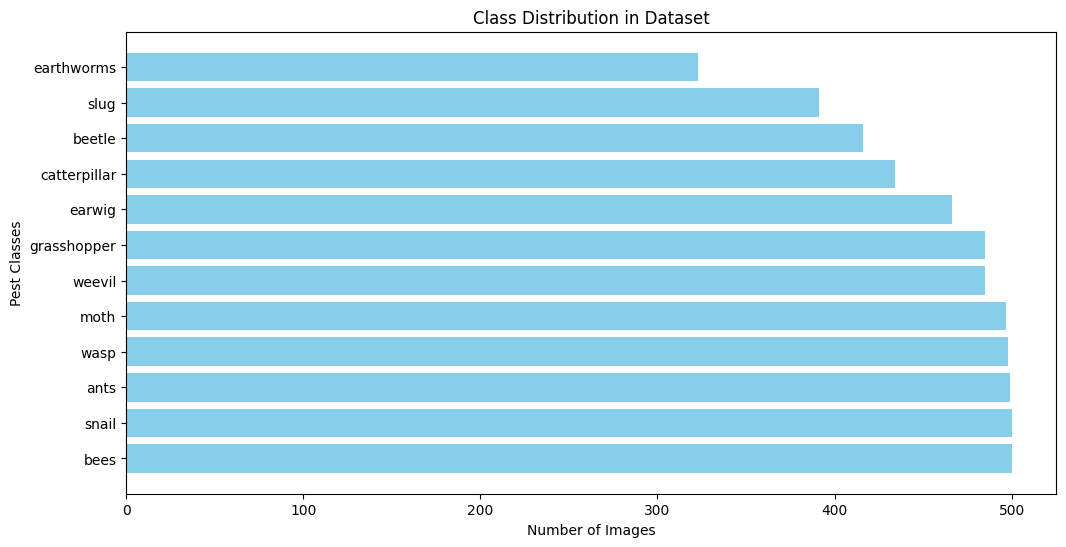

           Class  Count
7           bees    500
5          snail    500
1           ants    499
10          wasp    498
4           moth    497
11        weevil    485
8    grasshopper    485
2         earwig    466
3   catterpillar    434
9         beetle    416
6           slug    391
0     earthworms    323


In [ ]:
#Importing the os module
import os #Importing the necessary module to interact with the operating system
import pandas as pd
import matplotlib.pyplot as plt
#Checking Class Distribution (Imbalance Detection)
# Get class names (subfolders)
class_names = os.listdir(dataset_path)

# Count images per class
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in class_names}

# Convert to DataFrame for better visualization
df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
df = df.sort_values(by="Count", ascending=False)

# Plot class distribution
plt.figure(figsize=(12,6))
plt.barh(df["Class"], df["Count"], color='skyblue')
plt.xlabel("Number of Images")
plt.ylabel("Pest Classes")
plt.title("Class Distribution in Dataset")
plt.show()

print(df)


In [ ]:
# Load YOLO model
model_yolo = YOLO("yolov8m.pt")

In [ ]:
# Function to preprocess images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0  # Normalize
    return img

In [ ]:
# Load dataset and create image-label mappings
image_paths = []
labels = []
class_names = os.listdir(dataset_path)
class_indices = {class_name: i for i, class_name in enumerate(class_names)}

for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    for img_file in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, img_file))
        labels.append(class_indices[class_name])

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

In [ ]:
# Load MobileNetV3 model
base_model = MobileNetV3Small(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation="relu")(x)
output_layer = Dense(len(class_names), activation="softmax")(x)
model_mobilenet = Model(inputs=base_model.input, outputs=output_layer)

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile model
model_mobilenet.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
 #Data Augmentation
train_datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator()

In [ ]:
# Convert image paths to numpy array
X_train_images = np.array([preprocess_image(img_path) for img_path in X_train])
X_test_images = np.array([preprocess_image(img_path) for img_path in X_test])

In [ ]:
# Train model
history = model_mobilenet.fit(train_datagen.flow(X_train_images, np.array(y_train), batch_size=32),
                              validation_data=test_datagen.flow(X_test_images, np.array(y_test), batch_size=32),
                              epochs=10)

In [ ]:
# Evaluate model
y_pred = np.argmax(model_mobilenet.predict(X_test_images), axis=1)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 389ms/step
Classification Report:
               precision    recall  f1-score   support

  earthworms       0.00      0.00      0.00        65
        ants       0.00      0.00      0.00       100
      earwig       0.00      0.00      0.00        93
catterpillar       0.00      0.00      0.00        87
        moth       0.00      0.00      0.00        99
       snail       0.08      0.29      0.12       100
        slug       0.00      0.00      0.00        78
        bees       0.00      0.00      0.00       100
 grasshopper       0.10      0.70      0.17        97
      beetle       0.00      0.00      0.00        83
        wasp       0.00      0.00      0.00       100
      weevil       0.00      0.00      0.00        97

    accuracy                           0.09      1099
   macro avg       0.01      0.08      0.02      1099
weighted avg       0.02      0.09      0.03      1099



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


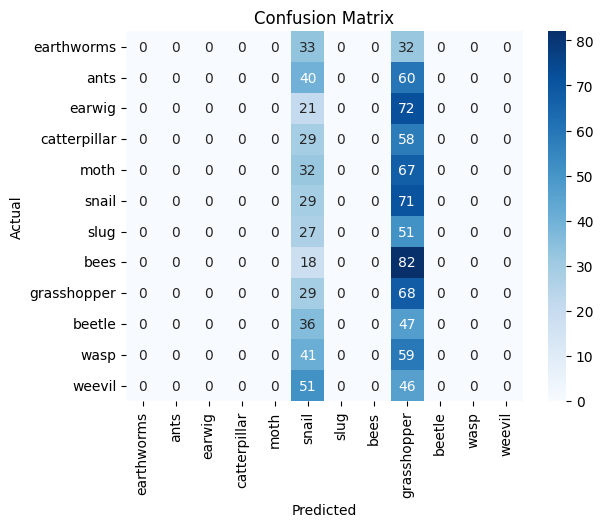

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Object Detection with YOLO
save_path = "./results"
os.makedirs(save_path, exist_ok=True)

for img_path in X_test:
    results = model_yolo.predict(source=img_path, conf=0.2, iou=0.5)
    res_plotted = results[0].plot()
    img = Image.fromarray(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
    img.save(f"{save_path}/{os.path.basename(img_path)}")



image 1/1 /content/dataset/earwig/earwig (259).jpg: 448x640 1 bird, 1 dog, 1293.6ms
Speed: 10.0ms preprocess, 1293.6ms inference, 29.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/dataset/ants/ants (7).jpg: 480x640 1 bird, 1796.8ms
Speed: 3.8ms preprocess, 1796.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/dataset/beetle/beetle (22).jpg: 480x640 (no detections), 1807.5ms
Speed: 5.9ms preprocess, 1807.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/dataset/beetle/beetle (65).jpg: 640x640 (no detections), 1566.3ms
Speed: 4.8ms preprocess, 1566.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/dataset/catterpillar/catterpillar (301).jpg: 640x448 1 banana, 1074.8ms
Speed: 2.9ms preprocess, 1074.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/dataset/weevil/Weevil (258).jpg: 384x640 1 person, 1 bird, 925

In [ ]:
for result in results:
    for box in result.boxes:
        class_id = box.cls[0].item()
        cords = box.xyxy[0].tolist()
        conf = box.conf[0].item()
        print(f"Class ID: {class_id}, Coordinates: {cords}, Confidence: {conf:.2f}")

In [ ]:
import numpy as np

# Example data (replace with actual values)
y_true = np.array([0, 1, 2, 1, 0])  # Replace with actual labels
y_pred = np.array([0, 2, 2, 1, 0])  # Replace with model predictions

# Find unique labels from y_true and y_pred
unique_labels = np.unique(np.concatenate((y_true, y_pred)))
print(f"Unique Labels: {unique_labels}")  # Debugging to ensure correctness

# Example class names (modify based on your dataset)
class_names = ['Pest_A', 'Pest_B', 'Pest_C']

# Ensure `unique_labels` is within valid range of class_names
filtered_class_names = [class_names[i] for i in unique_labels if i < len(class_names)]
print(f"Filtered Class Names: {filtered_class_names}")


print(f"Filtered Class Names: {filtered_class_names}")  # To check if this matches unique_labels
from sklearn.metrics import classification_report, confusion_matrix

# Generate the classification report with filtered class names
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=filtered_class_names))
# Confusion Matrix
print("Confusion Matrix:\n")
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

Unique Labels: [0 1 2]
Filtered Class Names: ['Pest_A', 'Pest_B', 'Pest_C']
Filtered Class Names: ['Pest_A', 'Pest_B', 'Pest_C']
Classification Report:

              precision    recall  f1-score   support

      Pest_A       1.00      1.00      1.00         2
      Pest_B       1.00      0.50      0.67         2
      Pest_C       0.50      1.00      0.67         1

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.78         5
weighted avg       0.90      0.80      0.80         5

Confusion Matrix:

[[2 0 0]
 [0 1 1]
 [0 0 1]]
